# Tutorial: JAX

The cell below will install the additional required dependencies using `pip` if running the notebook on [Google Colab](https://colab.research.google.com/) - it should do nothing if running locally.

In [ ]:
try:
    import google.colab
    # Running on Google Colab therefore install additional dependencies
    !pip install flax numpyro
except ImportError:
    # Assume dependencies installed if not running on Colab
    pass

## JAX: Intro

At a high level, jax is an extensible system for composable function transformations based on trace-specializing functional python code. These transformations include:

- Just In Time Compilation
- Automatic Differentiation
- Automatic Vectorization
- Single Program Multiple Device (SMPD) transformations.
- And more...



The functions on which jax can operate must:

- take a (collections of) tensor-like inputs and return (collections of) tensor-like outputs, which are instances of the `DeviceArray` class (similar to np.ndarry instances)
- manipulate these tensors using only a set of (closed) primitives exposed in the `jax` libraries, for the most part in the `jax.numpy` and `jax.scipy` modules, and which often have a direct equivalent in `numpy` or `scipy`
- be functionally pure: running the same function with the same inputs should yield the same outputs. Functional programming should feel natural when the code logic is the direct translation of mathemtatical operations, a case which is very frequent in Machine Learning.


We will start with a few very examples, and expand on that.

## Starting simple... The gaussian kernel

In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, grad, vmap

The `gaussian_kernel` function is a jax implementation of the famous gaussian kernel:
$$ k(x, y) = e^{-\frac{\|x - y\|^2}{\sigma^2}}$$

A function often used when implementing kernel-based methods, such as [Kernel Regression](https://en.wikipedia.org/wiki/Kernel_regression)

In [2]:
def gaussian_kernel(x, y):
    sigma = 2
    z = x - y
    return jnp.exp(-jnp.sum(jnp.square(z)) / sigma ** 2)

In [3]:
x_input = jnp.ones((2,))  # [0., 0.]
y_input = jnp.zeros((2,))  # [1., 1.]
retval = gaussian_kernel(x_input, y_input)
retval

DeviceArray(0.60653067, dtype=float32)

The gaussian kernel relies on the following jax primitives: `jnp.sum`, `jnp.square`, and `jnp.exp`, which are the jax-analogues of `np.sum`, `np.square` and `np.exp`. Almost all `numpy` primitives are present in `jax.numpy`, including traditional linear algebra operations like `jnp.dot` or `jnp.matmul`.

This function satisfies all the constraints enumerated in the introductory paragraph of this section: it takes as input 2 jax arrays, return a scalar (0-th order jax array), and is pure (same input->same output). We can thus apply jax transformations on it!

### Jax Transformations

### JIT compilation

In [4]:
# just-in-time compilation
jitted_gaussian_kernel = jit(gaussian_kernel)
assert gaussian_kernel(x_input, y_input) == gaussian_kernel(x_input, y_input)

The JIT-compiled version of `gaussian_kernel`, `jitted_gaussian_kernel` executes the same end-to-end mathematical operations, makes additional software and harware optimizations to speed up computations.

In [5]:
%timeit gaussian_kernel(x_input, y_input).block_until_ready()

14.5 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
%timeit jitted_gaussian_kernel(x_input, y_input).block_until_ready()

2.32 µs ± 63.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The speedup here is minimal, due to the fact that the function `gaussian_kernel` is quite simple: there is not much optimizations to perform.
We will see other use cases where the speedup yieled by jit-compilation of such functions can become significant.

### Automatic differentiation

Jax can compute derivatives of functions with respect to one or several arguments:

In [7]:
# automatic differentiation
d_dx_gaussian_kernel=grad(gaussian_kernel, argnums=0)  # compute the partial derivative of gaussian_kernel w.r.t x
d_dx_gaussian_kernel(x_input, y_input)  # returns a 2-d vector

DeviceArray([-0.30326533, -0.30326533], dtype=float32)

### Automatic vectorization

Last but not least, jax can also "automatically vectorize" a function. The vectorized function:
- takes as input a "batch" input tensors, stacked in a new dimension
- applies the original function to all  input tensors in the batch

In [8]:
vmapped_gaussian_kernel = vmap(gaussian_kernel, in_axes=(0, None))

In [9]:
batch_of_x_inputs = jnp.stack((jnp.zeros((2,)), jnp.ones((2,))))
vmapped_gaussian_kernel(batch_of_x_inputs, y_input)

DeviceArray([1.        , 0.60653067], dtype=float32)

### Arbitrary transformation composition

Importantly, all these transformations can be composed together (!):

In [10]:
jit(vmap(grad(gaussian_kernel), in_axes=(0, None)))(batch_of_x_inputs, y_input)

DeviceArray([[-0.        , -0.        ],
             [-0.30326533, -0.30326533]], dtype=float32)

With these basic building blocks in mind, we can start implementing interestiting mathematical and statistical objects. As you will see, using the function transformations provided by 
jax will often benefit you in one or multiple of the following ways:

- reduce code complexity, increase code readability
- increase code efficiency

### Exercise 1: Computing the (Gaussian Kernel) gram matrix between two datasets

As a first nontrivial composition exercise, try to implement a function that computes the **gram matrix** between two datasets $X = \{x_i\}_{i=1}^{n}$ and $X = \{y_i\}_{i=1}^{m}$, for a given kernel $k$. This gram matrix is given by:
    
    
$$
M = \begin{vmatrix}
k(x_1, y_1) & \dots & k(x_1, y_m)\\
\vdots & \ddots & \vdots \\
k(x_n, y_1) & \dots & k(x_n, y_m)\\
\end{vmatrix}
$$


In [11]:
import numpy as np
random_state = np.random.RandomState(42)
X = random_state.randn(100, 2)
Y = random_state.randn(200, 2)

#### numpy-style implementations

A naive implementation would consists in two nested for-loops that iterates over X and Y to compute each element of the matrix:

In [12]:
def compute_gram_matrix_naively(X, Y):
    gram_matrix = np.empty((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            kij = gaussian_kernel(X[i], Y[j])  # note the interoperability between jax and numpy arrays within **untransformed** jax funtions
            gram_matrix[i, j] = kij
    return gram_matrix

In [13]:
M_naive = compute_gram_matrix_naively(X, Y)

A more efficient implementation consists in leveraging numpy's broadcasting abilities to compute the entries of the gram matrix in a vectorized manner.
Note that this requires plumbing axis values in reduction operations happening during the kernel computation:

In [14]:
def gaussian_kernel_explicit_reduction_axes(x, y):
    sigma = 2
    z = x - y
    # we add a axis=-1 to prevent numpy from summing over all axes when giving gaussian_kernel a stack of tensors.
    # return jnp.exp(-jnp.sum(jnp.square(z)) / sigma ** 2)
    return jnp.exp(-jnp.sum(jnp.square(z), axis=-1) / sigma ** 2)

In [15]:
def compute_gram_matrix_bcast_semantics(X, Y):
    return gaussian_kernel_explicit_reduction_axes(X[:, None, :], Y[None, :, :])

In [16]:
M_bcast = compute_gram_matrix_bcast_semantics(X, Y)
assert np.allclose(M_naive, M_bcast)

Benchmarking these two functions highlights the dramatically higher efficiency of the latter method:

In [17]:
%timeit M_naive = compute_gram_matrix_naively(X, Y)

292 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit M_bcast = compute_gram_matrix_bcast_semantics(X, Y)

216 µs ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


However, the latter method required:

- rewriting `gaussian_kernel` to account for the case when it is given batched inputs. What if `gaussian_kernel` is replaced by a much more complex function? What is it is replaced by a third-party function that you are not familiar with?
- relying on broadcasting semantics in `compute_gram_matrix_bcast_semantics`: althought in that case, the use of such semantics was quite simple, its use in complex code base can quickly become error-prone.

#### Jax-implementation

In [19]:
# Exercise: combine of vmap and gaussian_kernel within compute_gram_matrix_using_vmap to compute the gram matrix between X and Y
def compute_gram_matrix_using_vmap(X, Y):
    # raise NotImplemented
    return vmap(vmap(gaussian_kernel, in_axes=(None, 0)), in_axes=(0, None))(X, Y)

In [20]:
M_vmap = compute_gram_matrix_using_vmap(X, Y)
assert np.allclose(M_vmap, M_bcast)

In [21]:
jitted_gaussian_kernel = jit(gaussian_kernel)
_ = jitted_gaussian_kernel(jnp.ones((2,)), jnp.zeros((2,))).block_until_ready()

### Exercise 2: A jax-implementation of the Kernelized Stein Discrepancy.


Further composition of `vmap`, `jit` and `grad` happens when computing the infamous `Stein` kernel, which is used to evaluate whether samples $\{x_i\}_{i=1}^{n}$ are distributed according to a test density $q(x) = p(x) / Z$ known up to a normalizing constant Z. Given some given kernel $k$, Writing $s(x) = \nabla \log p(x)$, the stein kernel writes:

$$
k_{\textrm{stein}}(x, y) = s(x)^\top s(y)k(x, y) + s(x)^\top \nabla_yk(x, y) + \nabla_x k(x, y)^\top s(y) + \textrm{div}_x(∇_yk(x, y))
$$

which can be used to compute a measure of discrepancy between the samples and the density $p$, called the Kernelized Stein Discrepancy (or KSD):

$$
\text{KSD}(p, x) = \sqrt{ \frac{1}{N^2} \sum_{i=1}^n \sum_{j=1}^n k_{\textrm{stein}}(x_i, y_j)}
$$

As an exercise, compute KSD between $p$ and  $X$ and using the gaussian kernel as the base kernel, and $p$ being standard normal distributio
We will place ourselves under the null hypothesis, meaning that $X$ will be sampled from $p$.

In [22]:
def p(x):
    return jnp.exp(-0.5 * jnp.sum(jnp.square(x))) #  unnormalized standard normal density

s = ...  # compute the score function

In [23]:
# Solution
s = grad(lambda x: jnp.log(p(x)))

In [24]:
# You will need the jacobian function transformation of jax, which computes the jacobian of a vector-valued function
from jax import jacobian

In [25]:
def stein_kernel(x, y):
    k = gaussian_kernel
    term_1 = jnp.dot(s(x), s(y)) * k(x, y)
    term_2 = jnp.dot(s(x), grad(k, argnums=1)(x, y))
    term_3 = jnp.dot(grad(k, argnums=0)(x, y), s(y))
    
    # Solution
    term_4 = jnp.trace(jacobian(grad(k, argnums=1), argnums=0)(x, y))
    
    return term_1 + term_2 + term_3 + term_4

In [26]:
def compute_gram_matrix_stein_kernel(X):
    return vmap(vmap(stein_kernel, in_axes=(None, 0)), in_axes=(0, None))(X, X)

In [27]:
def ksd(X):
    N = X.shape[0]
    return jnp.sqrt(jnp.sum(compute_gram_matrix_stein_kernel(X)) / (N **2))

In [28]:
from jax import random
key = random.PRNGKey(0)
X = random.normal(key, (5000,2))

Under the null hypothesis KSD(X, p) should tend to 0 at a $1/\sqrt{N}$ rate. Given that X is actually sampled from a unit gaussian, we should recover this regime if we implemented
the KSD properly. The following cells will plot the relationship between $1/\sqrt{N}$ and $\text{KSD}(X, p)$ for different sample size $N$ for X.

In [29]:
sample_sizes = (50, 100, 200, 300, 500, 1000, 2000, 5000)
random_state = np.random.RandomState(40)

ksd_vals = []
for N in sample_sizes:
    ksd_vals_this_iter = []
    for rs in range(5):
        X = random_state.randn(N, 2)
        ksd_vals_this_iter.append(ksd(jnp.array(X)))
    ksd_vals.append(jnp.mean(jnp.array(ksd_vals_this_iter)))

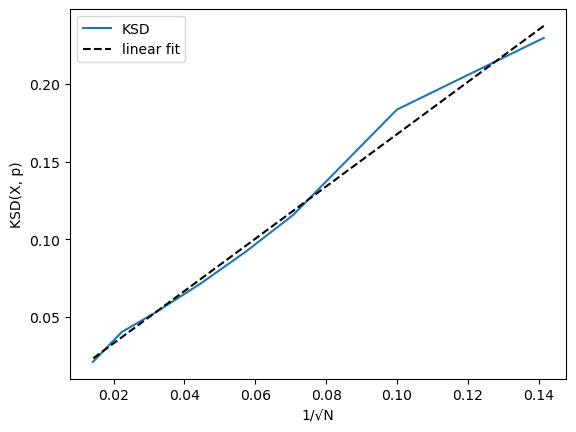

In [30]:
import matplotlib.pyplot as plt
plt.plot(1 / jnp.sqrt(jnp.array(sample_sizes)), ksd_vals, label="KSD")

coef = np.polyfit(1 / jnp.sqrt(jnp.array(sample_sizes)),ksd_vals,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(1 / jnp.sqrt(jnp.array(sample_sizes)), poly1d_fn(jnp.array(1 / jnp.sqrt(jnp.array(sample_sizes)))), '--k', label="linear fit")
plt.xlabel("1/√N")
plt.ylabel("KSD(X, p)")
plt.legend()

## Randomness in JAX

### Description 

- So far, we have conveniently evaded the notion of randomness in Jax by delegating draws from probability distributions to numpy.
- Random variables can be drawn from jax. However, the handling of randomness is an example of the functionalization constraint that jax imposes.
- his constrain prevents numpy-like random variables drawing, since drawing a random variable in numpy incurs a side effect by modifying numpy's random state:

In [31]:
def draw_one_random_variable():
    return np.random.randn()

In [32]:
print(draw_one_random_variable(), draw_one_random_variable())  # two different outputs for the same input (Φ): 

-0.07537296806232933 1.6193415953720864


`RandomState` Based randomness generation is also forbidden in functional programming frameworks, since it modifies its input:

In [33]:
def draw_one_random_variable_RandomState(rs):
    return rs.randn()

In [34]:
rs = np.random.RandomState(42)
orig_state = rs.get_state()

draw_one_random_variable_RandomState(rs)
np.allclose(rs.get_state()[1], orig_state[1])

False

Instead, `jax` generates random variables in a functionally pure manner by:
- requiring a one-off `PRNGKey`, a `RandomState` equivalent characterizing some pseudorandomness state.
- not alterating this key when generating a random variable



- The consequence of this pure randomness generation is that new keys must be repeteadly generated to "create" new randomness.
- Generating new keys from old ones is known in the computational pseudorandomness literrature as splitting, for which a utility function is provided in jax.

In [35]:
#                                           key 
#                                           | 
#                                           |  random.split(key)
#                                           | 
#                             ---------------------------
#                             |                          |
#                             |                          |
#                             |                          |
#                           subkey1                    subkey2
#                              | 
#     random.split(subkey1)    |                         |  random.split(subkey2)
#                              |                         | 
#                        --------------            --------------
#                        |            |            |            |
#                        |            |            |            |
#                        |            |            |            |
#                       subkey1.1   subkey1.2   subkey2.1      subkey2.2
#

In [36]:
from jax import random
key = random.PRNGKey(42)

key, subkey = random.split(key)
# provide a one-shot "RandomState"-like subkey to generate a random variable.
x1 = random.normal(subkey)

# From now on, subkey cannot be used since it was used to generate randomness in random.normal
x1_same = random.normal(subkey)
assert x1_same == x1

# You're left with an "untouched" new key that can be split to generate new randomness
key, subkey = random.split(subkey)

x2 = random.normal(subkey)
assert x2 != x1

### Exercise 3: re-plot the KSD values obtained from your previous exercise, but by generating random jax arrays natively this time!


In [37]:
from jax import random

sample_sizes = (50, 100, 200, 300, 500, 1000, 2000, 5000)

key = random.PRNGKey(0)

ksd_vals = []
for N in sample_sizes:
    ksd_vals_this_iter = []
    for rs in range(5):
        key, subkey = random.split(key)
        X = jax.random.normal(key, (N, 2))
        ksd_vals_this_iter.append(jit(ksd)(jnp.array(X)))
    ksd_vals.append(jnp.mean(jnp.array(ksd_vals_this_iter)))

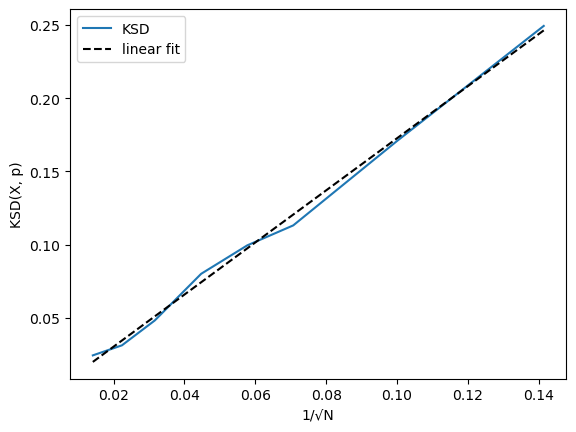

In [38]:
import matplotlib.pyplot as plt
plt.plot(1 / jnp.sqrt(jnp.array(sample_sizes)), ksd_vals, label="KSD")

coef = np.polyfit(1 / jnp.sqrt(jnp.array(sample_sizes)),ksd_vals,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(1 / jnp.sqrt(jnp.array(sample_sizes)), poly1d_fn(jnp.array(1 / jnp.sqrt(jnp.array(sample_sizes)))), '--k', label="linear fit")
plt.xlabel("1/√N")
plt.ylabel("KSD(X, p)")
plt.legend()

## Control-Flows in JAX

Understanding control flows in `jax` requires some additional digging of jax internals:

### A primer on jax internals: static shapes, functional purity


- Jax works by transforming a functionally pure function into a directed acyclic computation graph
- The interpreted nature of python makes the creation of this graph a challenge: such computation graphs are typically created ahead of time, during the compilation process when working with compiled languages.
- In intrepreted languages, the structure of the computational graph will be "discovered" at runtime, when executing the said program.

- To build this graph, jax relies on the amazing polymorphism capabilities of Python by substituting input to jax functions with special jax constructs called "tracers".
- These tracers progressively record the set of instructions applied on them, gathering the necessary informations to create a computational graph, called a "Jax Intermediate Representation", or JAX IR.
- This graph can then be traversed to perform computation graph transformations by defining appropritate transformation translation rules, leading to `vmap`, `jit`, `grad` etc.


Jax IRs can be described using a 1st order ANF called a `jaxpr`. Example is given below (credits to the Jax Team for the slides)

![title](./fun_to_jax_ir.png)

### Constructing jax-friendly control flows 

Additionally, as of now, `jaxpr`s are specialized to specific input and output shapes: thus, these shapes are required to be static, and cannot change depending on the value of the input. Thus, the following function:

In [39]:
def f(x):
    if x > 0:
        return jnp.ones((2,))
    else:
        return jnp.ones((3,))

will not yield a valid `jaxpr`, as the shape of the output depends on dynamic values (namely the values on the input).
Note however that because shapes are treated as static this:

In [40]:
def f(x):
    if x.shape[0] == 2:
        return jnp.ones((2,))
    elif x.shape[0] == 3:
        return jnp.ones((3,))
    else:
        raise ValueError

will yield a valid `jaxpr`, and can thus be subject to transformations.


#### Jax Conditionals

Note however, that even a modified version of the first function that would return outputs with identical shapes on both branches:

In [41]:
def f(x):
    if x > 0:
        return jnp.ones((2,))
    else:
        return jnp.zeros((2,))

is fundamentally incompatible with a tracing-based mechanism: within a single function call, a tracer will visit only one branch,
leading to an incomplete construction of the funciton's computational graph.

To solve this problem, jax exposes special control-flow primitives to be used in-lieu of Python control flows. Here is a jax-compatible rewrite of `f`,
using `jax.lax.cond`, the native jax if-statement primitive:

In [42]:
import jax.lax

def f(x):
    return jax.lax.cond(x > 0, lambda: jnp.ones((2,)), lambda: jnp.zeros((2,)))

In [43]:
print(f"{f(-1.)=}")
print(f"{f(2.)=}")

f(-1.)=DeviceArray([0., 0.], dtype=float32)
f(2.)=DeviceArray([1., 1.], dtype=float32)


#### Jax for-loops

for `for-loop` primitives, something different is at stake. Indeed, consider the following, (jax-valid) function

In [44]:
def f(x):
    for i in range(100):
        x = x+1
    return x

Unlike for the if-statement case, a jax-tracer will completely visit `f`'s computational graph. However, the tracer will not be aware of the loop-structure:

- Looking at the resulting computational graph, the loop will appear "unrolled", e.g. each iteration yielding it's independent sequence of operations.
- Statically unrolling python for-loops can become costly when the number of iterations increases, increasing the compilation time.

- As you may have figured it, jax exposes a for-loop special primitive, that lowers the entire loop to a single HLO For node.
- Using `jax.lax.cond` the user tells much more about the structure of the for loop than using a dynamic Pythonic for loop.
- In particular, all outputs of `body_fun` must keep the same shape across iterations

In [45]:
import jax.lax

def f_fori_loop(x):
    def body_fun(i, x):
        return x+1
    return jax.lax.fori_loop(0, 100, body_fun, x)

In [46]:
assert f(1) == f_fori_loop(1)

Note that this `fori_loop` does not capture intermediates iterates, but only the final iterate. Instead, use `jax.lax.scan` to capture all intermediate iterates.

### Exercise 4: implementing a Monte-Carlo Markov Chain Algorithm


- A Monte-Carlo Markov Chain algorithm is an algorithm that can be used to approximately sample from an unnormalized probabilty distribution p.
- MCMC algorithm srepeateadly generates iterates $x_i$ by drawing them from a **Markov Kernel** $k(x_{i-1}, \cdot)$, a distributution parametrized by $x_{i-1}$ and which admits $p$ as an invariant distribution:

$$
\int k(x, y) p(x) = p(y)
$$

A famous family of kernels are Metropolis Hasting kernels, which, given some input $x$ (typically, $x_{i-1}$ during a loop), are parametrized by a proposal distribution $q(\cdot | x)$ and are described by the following probabilistic program:


**How to sample from $k(\cdot, x)$**

- generate $x' \sim q(\cdot|x)$
-  $\alpha = \frac{p(x')q(x | x')}{p(x)q(x'|x)}$
-  with prob. $\min(\alpha, 1)$, return x'. Else, return x.

The goal of this exercise is to write an efficient implementation of a MCMC algorithm with for some target density $p(x)$ given below, random walk MH kernel,  which is a MH kernel characetrized by the proposal distribution $q(x, y) = \mathcal N(x-y, \sigma^2 I_2)$. 

Importantly, this proposal is symmetric $q(x|x')=q(x'|x)$. Thus, the computation of $\alpha$ reduces to $p(x')/p(x)$.
  

To complete this algorithm you will have to:
- implement the random walk kernel
- create the for-loop representing the MCMC algorith, using a jax.lax.scan primitive

In [47]:
def p(x):
    
    # the unnormalized density of interest
    sigma = 1.
    return jnp.exp(-0.5/sigma**2 * jnp.sum(jnp.square(x - jnp.ones((2,)))))

In [48]:
# the proposal distribution q(\cdot | x)
def q(x, y):
    return jnp.exp(-0.5/sigma**2 * jnp.sum(jnp.square(x - y)))

def random_walk_kernel(x, key, sigma=1):
    # 1. generate x' from q(x, \cdot). Hint: use a shifted and scaled sample from random.normal.
    # 2. compute \alpha
    # 3. return x or x'.
    raise NotImplemented

 Careful! there should not be native if statements! try running a jitted version of `random_walk_kernel`
 


In [49]:
x0 = jnp.zeros((2,))
key = random.PRNGKey(0)

x1 = random_walk_kernel(x0, key)
x1_jitted = jit(random_walk_kernel)(x0, key)

assert jnp.allclose(x1, x1_jitted)

TypeError: exceptions must derive from BaseException

For the next step, implement a full MCMC algorithm by iteratively sampling from this kernel.
Below is a for-loop equivalent:

In [ ]:
def rw_mcmc(num_steps, x0, key):
    x = x0
    iterates = [x]
    for i in range(steps):
        key, subkey = random.split(key)
        x = random_walk_kernel(x, subkey)
        iterates.append(x)
    return iterates

Fill the following code:

In [ ]:
def rw_mcmc_jax_control_flow(num_steps, x0, key):
    x = x0
    iterates = [x]
    
    def step_fn(carry, input_):
        output = ...  # do a MH kernel step
        return output, output
    
    # call jax.lax.scan using step_fn as its step function.
    _, iterates  = jax.lax.scan(...)
    return iterates

You will notice how much faster the version of  `rw_mcmc` using jax.lax control flow is as opposed to its Python counterpart!

## Extending the flexibility of jax functions with PyTrees


### A Primer on PyTrees 

The aforementioned fact that valid `jax` functions could only take `jax` arrays as inputs and return `jax` arrays is a slight reduction. Actually, jax functions can take as inputs arbitrary nested collections  JAX arrays. These nested collections are called PyTrees.

- Collections that defines valid PyTrees by defaults are tuples, namedtuple, lists, dictionaries. PyTrees are characetrized by the structure or the nested collections (where the cardinality of each collection is a static attribute of the PyTree structure, i.e cannot change across instances of this pytree structure). Such collections have a tree structure (hence the name), and the leaves are the array.
- The structure of the PyTree is called a PyTreeDef

In [ ]:
# Example
some_pytree = {'a': jnp.ones((2,)), 'b': jnp.ones((2,))}

The principles applying to jax arrays mostly generalize to PyTrees. For instances, shapes must be known statically. This function for example is invalid jax code

In [ ]:
def f():
    return jax.lax.cond(True, lambda: [jnp.ones((2,)), jnp.ones((3,))], lambda: [jnp.ones((3,)), jnp.ones((3,))])

Pytrees can be differentiated of vmapped against:

In [ ]:
def f(tree):
    return 2 * tree['a']['c'] * tree['b']

In [ ]:
grad_f = grad(f)
grad_f({'a': {'c': 10.}, 'b': -2.})

In [ ]:
vmapped_f = vmap(f)
vmapped_f({'a': {'c': 10. * jnp.ones((10,))}, 'b': -2. * jnp.arange(10)})

All such operations can be done only on part of the PyTree structure of each argument:

In [ ]:
vmapped_f_partial = vmap(f, in_axes=({'a': {'c': 0}, 'b': None}, ))  # a bit error-prone: this is currently a jax usability weak spot.
vmapped_f_partial({'a': {'c': 10. * jnp.ones((10,))}, 'b': -2.})

 pytrees are useful to represent the internal state (e.g. the weights, the batch norm statistics, etc) of a neural network, as often, neural network have a nested/hierechical/modular structure.

### Convenients PyTrees

Two important remarks on PyTree are in order:

- NamedTuple are PyTree. Using namedtuples often prevent extenive kwargs plumbing in functions, by gathering all "configuration" arguments (as opposed to actual variables) to a function within a `Config` NamedTuple Umbrella (note that all attributes of the named tuple must be tracable!).

In [ ]:
from typing import NamedTuple
class MyAlgorithmConfig(NamedTuple):
    learning_rate: int = 0.01
    regularization_val: int = 0.001
    # careful! if the training loop was implememted as a jax.lax.scan loop,
    # num_iter will have to be static, as it impacts the output shape of the scan loop
    # num_iter = 100
    ...

In [ ]:
def train_my_network(X, y, my_algorithm_config: MyAlgorithmConfig,
                     # num_iter = 100
                    ):
    ...
    
# instead of
def train_my_network(X, y, learning_rate, regularization_val, 
                     # num_iter = 100
                    ):
    ...

- Additional User-Defined Collection Types can be registered as PyTreeNodes, using the jax.tree_util.register_pytree_node_class
- However, `flax`, a jax-powered neural network library, exposes a `struct.PyTreeNode` helper allowing the extremly useful operation:
  - automatically register dataclass-like classes...
  - ...while manually specifying which arguments are static and which are traceable! Thanks to this, `num_iter` in the previous example can be safely ignored:
  

In [ ]:
from flax import struct

class MyAlgorithmConfig(struct.PyTreeNode):
    learning_rate: int = 0.01
    regularization_val: int = 0.001
    # num_iter can be marked as static!
    num_iter: int = struct.field(pytree_node=False, default=100)

## A final End-to-end example. Mixture of Gaussians:

### What This Example shows

This final example is an end-to-end macro-example showcasing the capabilities of jax on a end-to-end algorithm with a few subtlelties: a mixture of gaussian algorithms. In particular, this examples demostrates:

- the functional nature of jax through the use of functional slice setting semantics (x = x.at[i].set(y))
- the use of user-defined PyTrees, both as input and output algorithm
- top-level use of jax.vmap to seamlessly vectorize the algorithm over random initializations

### Show Me the Code

In [ ]:
from typing import NamedTuple

import jax
import jax.numpy as jnp
from flax import struct
from jax import random
from jax._src.api import vmap
from jax.nn import log_softmax, logsumexp
from jax.tree_util import tree_map
from jax.flatten_util import ravel_pytree  # type: ignore
from numpyro import distributions as np_distributions
import numpy as np

from typing import Any
Array, Numeric, PRNGKeyArray = Any, Any, Any

In [ ]:
class MOGDistribution(np_distributions.Distribution):
    def __init__(self, cluster_means: Array, cluster_covs: Array, cluster_props: Array):
        assert len(cluster_means.shape) == 2
        self._num_clusters, self._num_dims = cluster_means.shape
        self.cluster_means = cluster_means

        assert len(cluster_props.shape) == 1
        self.cluster_props = cluster_props

        self.cluster_covs = cluster_covs

        self._dists = np_distributions.MultivariateNormal(
            cluster_means, covariance_matrix=cluster_covs
        )

        super(MOGDistribution, self).__init__(
            batch_shape=(), event_shape=(self._num_dims,)
        )

    def log_prob(self, x: Array):
        assert len(x.shape) == 1
        return logsumexp(self._dists.log_prob(x), b=self.cluster_props)

    def _sample_from_cluster_idx(self, key, idx):
        return tree_map(lambda d: d[idx], self._dists).sample(key)

    def sample(self, key: PRNGKeyArray, sample_shape: tuple = ()) -> Array:
        if sample_shape == tuple():
            sample_shape = (1,)

        key, key_latent = random.split(key)

        mn = np_distributions.Categorical(probs=self.cluster_props)
        idxs = mn.sample(key_latent, sample_shape=sample_shape)
        keys_observed = random.split(key, num=sample_shape[0])
        return vmap(self._sample_from_cluster_idx, in_axes=(0, 0))(  # type: ignore
            keys_observed, idxs
        )

In [ ]:
class MOGTrainingConfig(struct.PyTreeNode):
    num_clusters: int = struct.field(pytree_node=False)
    max_iter: int = struct.field(pytree_node=False)
    num_inits: int = struct.field(pytree_node=False)
    min_std: float = struct.field(pytree_node=True, default=0.01)
    max_train_samples: int = struct.field(pytree_node=False, default=1000)
    cov_reg_param: int = struct.field(pytree_node=False, default=1e-6)

In [ ]:
def _kmeans_plus_plus_init(data: Array, num_clusters: int, key: PRNGKeyArray) -> Array:
    num_points, num_dim = data.shape
    clusters = jnp.empty((num_clusters, num_dim))

    init_cluster_data_idx = random.choice(key, a=num_points)
    init_cluster_center = data[init_cluster_data_idx, :]

    this_cluster_center = init_cluster_center
    clusters = clusters.at[0, :].set(this_cluster_center)

    all_sq_dists = jnp.inf * jnp.ones((num_points, num_clusters))

    for i in range(num_clusters - 1):
        sq_dists = jnp.sum(jnp.square(data - this_cluster_center), axis=1)

        all_sq_dists = all_sq_dists.at[:, i].set(sq_dists)
        min_sq_dists = jnp.min(all_sq_dists, axis=1)

        key, subkey = random.split(key)
        next_cluster_idx = random.categorical(
            subkey, logits=jnp.log(min_sq_dists + 1e-15)
        )
        next_cluster_center = data[next_cluster_idx]

        this_cluster_center = next_cluster_center
        clusters = clusters.at[i + 1, :].set(this_cluster_center)

    return clusters

In [ ]:
class MOGResult(NamedTuple):
    # don't return a MOGDistribution because numpyro Distributions objects are not
    # vmap-able
    min_std: float
    cluster_init: Array
    cluster_means: Array
    cluster_covs: Array
    cluster_props: Array
    log_probs: Array
    final_log_prob: Numeric
    converged: bool
    num_iter_convergence: Numeric

    def to_dist(self) -> MOGDistribution:
        return MOGDistribution(
            self.cluster_means, self.cluster_covs, self.cluster_props
        )

In [ ]:
def _fit_one_mog(
    data: Array, num_clusters: int, min_std: float, max_iter: int,
    max_train_samples: int, cov_reg_param: float, key: PRNGKeyArray
) -> MOGResult:
    num_points, num_dims = data.shape

    assert len(data.shape) == 2
    # TODO: kmeans++?

    if data.shape[0] > max_train_samples:
        key, subkey = random.split(key)
        data = random.permutation(subkey, data, axis=0)
        data = data[:max_train_samples]

    # init_cluster_data_idx = random.choice(key, a=num_points, shape=(num_clusters,))

    # cluster_means = data[init_cluster_data_idx]
    key, key_init = random.split(key)
    init_cluster_means = _kmeans_plus_plus_init(data, num_clusters, key_init)
    init_cluster_covs = jnp.stack(
        [jnp.eye(num_dims) for _ in range(num_clusters)], axis=0
    )

    log_cluster_props = -np.log(num_clusters) * jnp.ones((num_clusters,))

    log_prob = prev_log_prob = -jnp.inf

    iter_no = 0
    assert max_iter > 0

    converged = False
    num_iter_convergence = 0

    log_probs = jnp.empty((max_iter,))

    cluster_means = init_cluster_means
    cluster_covs = init_cluster_covs


    for iter_no in range(max_iter):
        dists = np_distributions.MultivariateNormal(
            cluster_means,
            covariance_matrix=cluster_covs,
        )
        log_joint = dists.log_prob(data[:, None, :]) + log_cluster_props[None, :]

        log_prob = logsumexp(log_joint, axis=1).mean()
        log_probs = log_probs.at[iter_no].set(log_prob)

        # assert log_prob - prev_log_prob > -1e-6
        converged = jnp.abs(log_prob - prev_log_prob) < 1e-4
        num_iter_convergence += 1 - converged

        # E-step: compute posterior p(z=k|x) (num_points, num_clusters)
        log_resps = log_softmax(log_joint, axis=1)

        # M-step
        # data: (num_points, dim)
        # normalized_data_weights: (num_points,num_clusters)
        normalized_data_weights = jax.nn.softmax(log_resps, axis=0)
        cluster_means = jnp.sum(data[:, None, :] * normalized_data_weights[:, :, None], axis=0)

        log_cluster_props = jax.nn.log_softmax(jax.nn.logsumexp(log_resps, axis=0))

        def _compute_cov(mean, weights):
            return (
                (data - mean).T @ jnp.diag(weights) @ (data - mean) + cov_reg_param * jnp.eye(num_dims)
            )

        cluster_covs = vmap(_compute_cov, in_axes=(0, 1))(cluster_means, normalized_data_weights)  # type: ignore

        prev_log_prob = log_prob

    def smooth_cov(cov_mat):
        from jax.numpy.linalg import eigh
        eigvals, eigvecs = eigh(cov_mat)
        return eigvecs @ jnp.diag(jnp.clip(jnp.real(eigvals), a_min=min_std ** 2)) @ eigvecs.T

    cluster_covs = vmap(smooth_cov)(cluster_covs)
    return MOGResult(
        min_std,
        init_cluster_means,
        cluster_means,
        cluster_covs,
        jax.nn.softmax(log_cluster_props),
        log_probs,
        log_prob,
        converged,
        num_iter_convergence,
    )

In [ ]:
def fit_mog(data: Array, config: MOGTrainingConfig, key: PRNGKeyArray) -> MOGResult:
    keys = random.split(key, num=config.num_inits)
    vmapped_fit = vmap(_fit_one_mog, in_axes=(None, None, None, None, None, None, 0))  # type: ignore
    rets = vmapped_fit(data, config.num_clusters, config.min_std, config.max_iter,
                       config.max_train_samples, config.cov_reg_param, keys)

    print(rets.final_log_prob)
    best_fit_idx = jnp.argmax(rets.final_log_prob)
    return tree_map(lambda l: l[best_fit_idx], rets)


In [ ]:
data = jnp.concatenate([
    np_distributions.Normal(0, 0.25).sample(random.PRNGKey(0), (1000, 2)),
    np_distributions.Normal(1, 0.25).sample(random.PRNGKey(1), (1000, 2)),
    np_distributions.Normal(2, 0.25).sample(random.PRNGKey(2), (1000, 2))
    ], axis=0)

# fix the algorithm by increasing the number of clusters
ret = fit_mog(data, MOGTrainingConfig(2, 100, 3, 0.01), random.PRNGKey(1))

In [ ]:
simulated_data = ret.to_dist().sample(random.PRNGKey(3), sample_shape=(len(data),))

In [ ]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.scatter(data[:, 0], data[:, 1], s=3)
ax1.set_title('training data')

ax2.scatter(simulated_data[:, 0], simulated_data[:, 1], s=3)
ax2.set_title('MoG-simulated data')

#### Jax and Functional purity

As mentioned above, operates only on functionally pure programs (no side effect).
This "no side effect" policy, applied to the nested structure of computer programs, imply that variables cannot be modified.

- Imposing Such constraints constituted a natural first step for building a framework as complex as jax, being ensuring a Smaller Surface Area for Compilation.
- Functionally pure programs imply very handy property called "referential transparency". A refenrentially transparent program can be extensively optimized by compilers.

The functionaly purity requirement imposed by jax imposes python-program rethinking, especially at the control-flow levels. In addition to yield static shapes, branching and iterations need to be "purified"